In [1]:
#####Switching Latent Decomposition model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

In [3]:
####データの生成####
##データの設定
k1 = 10
k2 = 10
k3 = 7
company = 3500
item = 4000
element = 300
segment = 500
Lambda = np.random.gamma(27.5, 1/0.2, company)
pt = np.random.poisson(Lambda, company)
hhpt = np.sum(pt)
m = np.random.poisson(2.75, company)
m[m < 1] =1; m[m > 7] = 7
M = np.sum(m)
vec_k1 = np.repeat(1, k1); vec_k2 = np.repeat(1, k2); vec_k3 = np.repeat(1, k3)

In [4]:
##IDとインデックスを作成
#IDの作成
d_id = np.repeat(np.arange(company), pt)
s_id = np.repeat(np.arange(company), m)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(company)])))

#インデックスの設定
d_list = [i for i in range(company)]
s_list = [i for i in range(company)]
d_vec = [i for i in range(company)]
for i in range(company):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")
    s_list[i] = np.array(np.where(s_id==i)[0], dtype="int")
    d_vec[i] = np.repeat(1, d_list[i].shape[0])
d_dt = sparse.coo_matrix((np.repeat(1, hhpt), (d_id, range(hhpt))), shape=(company, hhpt)).tocsr() 

In [5]:
##セグメントと構成比を生成
#トピック割当を生成
topic = 25
theta_topic = np.random.dirichlet(np.repeat(0.2, topic), company)
gamma_segment = np.random.gamma(7.5, 1/0.15, segment)
phi_segment = np.random.dirichlet(np.repeat(0.25, segment), topic)
phi_item = np.random.dirichlet(np.repeat(0.25, item), segment)
phi_element = np.random.dirichlet(100*np.random.dirichlet(np.repeat(1.0, element), 1).reshape(-1), item)

#多項分布からセグメントと構成比を生成
max_m = np.max(m)
m_vec = np.repeat(1.0, max_m)
Si = np.array(np.full((company, max_m), segment), dtype="int16")
Composition = np.zeros((company, max_m))
for i in range(company):
    #セグメントを生成
    z = np.dot(np.random.multinomial(1, theta_topic[i, ], m[i]), np.arange(topic))
    s = np.repeat(segment, max_m)
    phi = phi_segment.copy()
    for j in range(m[i]):
        s[j] = np.argmax(np.random.multinomial(1, phi[z[j], ], 1))
        phi[:, j] = 0
    Si[i, ] = s
    
    #構成比を生成
    if m[i] > 1:
        Composition[i, np.arange(m[i])] = np.random.dirichlet(gamma_segment[Si[i, ][np.arange(m[i])]], 1).reshape(-1)
    else:
        Composition[i, 0] = 1.0
        
#ベクトルに変換
Si_long = np.array(Si[d_id, ], dtype="int16")
s_vec = Si.reshape(-1); s_vec = s_vec[s_vec!=segment]
c_vec = Composition.reshape(-1); c_vec = c_vec[c_vec > 0.0]

In [6]:
##アイテムを生成
#データの格納用配列
segment_id = np.repeat(0, hhpt)
item_id = np.repeat(0, hhpt)

#多項分布からアイテムとセグメントを生成
for i in range(company):
    index = d_list[i]
    segment_id[index] = Si[i, np.arange(m[i])][np.dot(np.random.multinomial(1, Composition[i, np.arange(m[i])], pt[i]), np.arange(m[i]))]
    item_id[index] = rmnom(phi_item[segment_id[index], ], pt[i], item, 0)
    
#インデックスを定義
segment_list = [i for i in range(segment)]
item_list = [i for i in range(item)]
segment_n = np.repeat(0, segment)
item_n = np.repeat(0, item)
for i in range(segment):
    segment_list[i] = np.array(np.where(Si_long==i)[0], dtype="int")
    segment_n[i] = segment_list[i].shape[0]
for i in range(item):
    item_list[i] = np.array(np.where(item_id==i)[0], dtype="int")
    item_n[i] = item_list[i].shape[0]

In [7]:
##セグメントの観測フラグを生成
#観測確率を生成
k = 10
beta = 0.25
embedding_item = np.random.normal(0, 1.0, item*k).reshape(item, k)
embedding_segment = np.random.normal(0, 1.0, segment*k).reshape(segment, k)
mu = beta + np.sum(embedding_item[item_id, ] * embedding_segment[segment_id, ], axis=1)
Prob = np.exp(mu) / (1 + np.exp(mu))

#ベルヌーイ分布からフラグを生成
segment_flag = np.random.binomial(1, Prob, hhpt)
segment_flag[np.where(m[d_id]==1)[0]] = 1
index_flag1 = np.array(np.where(segment_flag==1)[0], dtype="int")
index_flag0 = np.array(np.where(segment_flag==0)[0], dtype="int")

##セグメントの観測頻度を集計
#観測セグメントを割当て
segment_allocation = np.zeros((hhpt, max_m), dtype="int16")
Si_long = Si[d_id, ]
segment_id0 = segment_id.copy()
segment_id0[index_flag0] = segment
for i in range(segment):
    index1 = np.array(np.where(segment_id0==i)[0], dtype="int")
    index2 = np.array(np.where(Si_long[index1, ]==i)[1], dtype="int")
    s = index1.shape[0]
    for j in range(s):
        segment_allocation[index1[j], index2[j]] = 1
        
#観測頻度を割当て
segment_obz = np.zeros((company, max_m), dtype="int16")
for i in range(company):
    segment_obz[i, ] = np.sum(segment_allocation[d_list[i], ], axis=0)

In [8]:
##エレメントの割当を生成
#多項分布からエレメントを生成
element_id = rmnom(phi_element[item_id, ], hhpt, element, 0)

#インデックスを定義
element_list = [i for i in range(element)]
element_n = [i for i in range(element)]
for i in range(element):
    element_list[i] = np.array(np.where(element_id==i)[0], dtype="int")
    element_n[i] = element_list[i].shape[0]

In [10]:
####応答変数を生成####
per_min = 75; per_max = 75
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    ##パラメータを生成
    #レコードごとの頻度を生成
    freq = np.random.poisson(30.0, hhpt)
    freq[freq < 5] = 5
    N = np.sum(freq)

    #事前分布の定義
    alpha = np.array([0.0])
    alpha_u = np.repeat(0.0, k1)
    alpha_s1 = np.repeat(0.0, k1)
    alpha_v = np.repeat(0.0, k2)
    alpha_s2 = np.repeat(1.0, k2)
    alpha_e = np.repeat(1.0, k3)
    tau_u = np.array([0.7])
    tau_v = np.array([0.5])
    tau_e = np.array([0.3])
    Cov_u = np.diag(np.repeat(0.3, k1))
    Cov_s1 = np.diag(np.repeat(0.3, k1))
    Cov_v = np.diag(np.repeat(0.3, k2))
    Cov_s2 = np.diag(np.repeat(0.25, k2))
    Cov_e = np.diag(np.repeat(0.2, k3))
    alphat = alpha.copy(); alphat_u = alpha_u.copy(); alphat_s1 = alpha_s1.copy()
    alphat_v = alpha_v.copy(); alphat_s2 = alpha_s2.copy(); alphat_e = alpha_e
    taut_u = tau_u.copy(); taut_v = tau_v.copy(); taut_e = tau_e.copy()
    Covt_u = Cov_u.copy(); Covt_s1 = Cov_s1.copy(); Covt_v = Cov_v.copy()
    Covt_s2 = Cov_s2.copy(); Covt_e = Cov_e.copy()

    #モデルパラメータの生成
    Sigma = np.array([1.0])
    beta = np.array([-0.5])
    beta_u = np.random.normal(alpha, tau_u, company)
    beta_v = np.random.normal(alpha, tau_v, item)
    beta_e = np.random.normal(alpha, tau_e, element)
    theta_u = np.random.multivariate_normal(alpha_u, Cov_u, company)
    theta_s1 = np.random.multivariate_normal(alpha_s1, Cov_s1, segment)
    theta_v = np.random.multivariate_normal(alpha_v, Cov_v, item)
    theta_s2 = np.random.multivariate_normal(alpha_s2, Cov_s2, segment)
    theta_e = np.random.multivariate_normal(alpha_e, Cov_e, element)
    omega1 = np.random.normal(0.0, 0.2, k1*k2*k3).reshape(k1, k2, k3)
    omega2 = omega1 + np.random.normal(0.0, 0.1, k1*k2*k3).reshape(k1, k2, k3)
    betat = beta.copy(); betat_u = beta_u.copy(); betat_v = beta_v.copy(); betat_e = beta_e.copy()
    thetat_u = theta_u.copy(); thetat_s1 = theta_s1.copy(); thetat_v = theta_v.copy()
    thetat_s2 = theta_s2.copy(); thetat_e = theta_e.copy()
    omegat1 = omega1.copy(); omegat2 = omega2.copy()

    ##モデルの期待値から応答変数を生成
    #タッカー分解の期待値
    uv1 = np.repeat(0.0, hhpt); uv2 = np.repeat(0.0, hhpt)
    joint_theta = theta_v[item_id, ] * theta_s2[segment_id, ]
    for j in range(k3):
        uv1 += np.dot(np.dot(theta_s1, omega1[:, :, j])[segment_id, ] * joint_theta * theta_e[element_id, j][:, np.newaxis], vec_k2)
        uv2 += np.dot(np.dot(theta_u, omega2[:, :, j])[d_id, ] * joint_theta * theta_e[element_id, j][:, np.newaxis], vec_k2)
    mu = beta + beta_u[d_id] + beta_v[item_id] + beta_e[element_id] + uv1 + uv2

    #二項分布から応答変数を生成
    Prob = scipy.stats.norm.cdf(mu, 0, Sigma)
    y = np.random.binomial(freq, Prob, hhpt)
    data = np.hstack((y[:, np.newaxis], (freq-y)[:, np.newaxis], freq[:, np.newaxis]))
    y_vec = np.repeat(np.tile(np.arange(2)[::-1], hhpt), data[:, :2].reshape(-1))

    #break条件
    if (np.sum(y)/N > 0.3) & (np.sum(y)/N < 0.5) & (np.sum(mu <= -7.5) < hhpt/per_min) & (np.sum(mu > 7.5) < hhpt/per_max):
        break

1
2


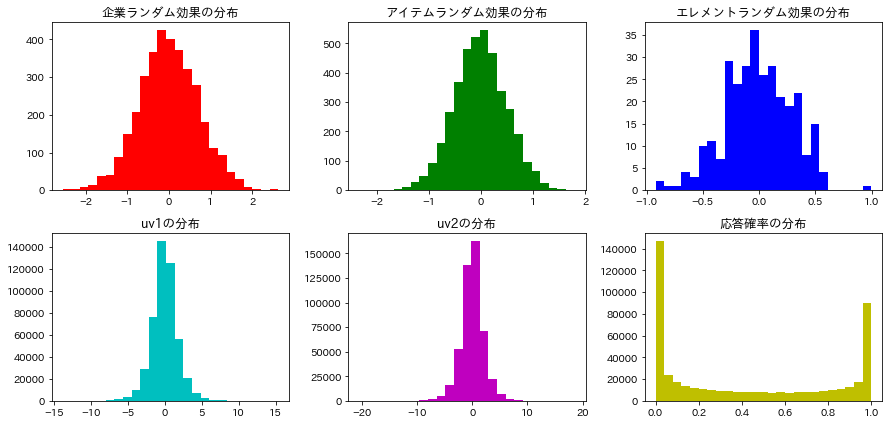

In [11]:
#生成したデータのヒストグラム
dt = [beta_u, beta_v, beta_e, uv1, uv2, Prob]
fig_range = np.append(np.array([np.min(beta_u), np.min(beta_v), np.min(beta_e), np.min(uv1), np.min(uv2), 0.0]), 
                      np.array([np.max(beta_u), np.max(beta_v), np.max(beta_e), np.max(uv1), np.max(uv2), 1.0])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["企業ランダム効果の分布", "アイテムランダム効果の分布", "エレメントランダム効果の分布",
          "uv1の分布", "uv2の分布", "応答確率の分布"]
fig = plt.figure(figsize=(12.5, 6.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [12]:
####Hierarchical embedding model with aux Infomationを推定####
##切断正規分布の乱数を発生させる関数
def rtnorm1(mu, mu_vec, Sigma, record_id1, record_id2, index_record1, index_record2, a, b, N, N1, N2):
    U = np.repeat(0.0, N)
    FA = norm.cdf(a, mu, Sigma)
    FB = norm.cdf(b, mu, Sigma)
    U[index_record1] = norm.ppf(np.random.uniform(0, 1, N1)*(FB-FA)[record_id1]+FA[record_id1], mu_vec[index_record1], Sigma)
    U[index_record2] = norm.ppf(np.random.uniform(0, 1, N2)*FA[record_id2], mu_vec[index_record2], Sigma)
    return U

def rtnorm2(mu, sigma, a, b, n):
    FA = norm.cdf(a, mu, sigma)
    FB = norm.cdf(b, mu, sigma)
    return norm.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu, sigma)

In [13]:
##ベイジアン多変量回帰モデルをギブスサンプリングする関数
def rmultireg(Y, X, inv_XXV, XY, Cov, ADelta, Deltabar, V, nu, n, col, k):
    #事後分布のパラメータを設定
    beta_mu = np.dot(inv_XXV, XY + np.dot(ADelta, Deltabar)).T.reshape(-1)   #平均ベクトル
    sigma = np.kron(Cov, inv_XXV)   #分散共分散行列

    #パラメータをサンプリング
    beta_vec = np.random.multivariate_normal(beta_mu, sigma, 1)
    beta = beta_vec.reshape(col, k, order='F')   #回帰行列に変換

    
    ##逆ウィシャート分布から分散共分散行列をサンプリング
    #モデル誤差を設定
    mu = np.dot(X, beta)
    er = Y - mu

    #逆ウィシャート分布のパラメータ
    IW_R = np.dot(er.T, er) + V
    Sn = n + nu

    #パラメータをサンプリング
    Cov = scipy.stats.invwishart.rvs(Sn, IW_R, 1)
    return beta, Cov

In [14]:
##アルゴリズムの設定
R = 2000
keep = 10
burnin = int(100/keep)
iter = 0
disp = 10

In [15]:
##データの設定
#切断領域を定義
rho = 100.0
a = np.repeat(0.0, hhpt)
b = np.repeat(rho, hhpt)
flag =  y_vec - (1-y_vec)

#頻度を集計
d_freq = np.repeat(0, company)
item_freq = np.repeat(0, item)
segment_freq = np.repeat(0, segment)
element_freq = np.repeat(0, element)
for i in range(company):
    d_freq[i] = np.sum(freq[d_list[i]])
for i in range(item):
    item_freq[i] = np.sum(freq[item_list[i]])
for i in range(segment):
    segment_freq[i] = np.sum(freq[segment_list[i]])
for i in range(element):
    element_freq[i] = np.sum(freq[element_list[i]])

#レコードidを設定
intercept = np.repeat(1.0, hhpt)[:, np.newaxis]
record_id = np.repeat(np.arange(hhpt), freq)
record_id1 = np.repeat(np.arange(hhpt), data[:, 0])
record_id2 = np.repeat(np.arange(hhpt), data[:, 1])
index_record1 = np.array(np.where(y_vec==1)[0], dtype="int")
index_record2 = np.array(np.where(y_vec==0)[0], dtype="int")
N1 = index_record1.shape[0]
N2 = index_record2.shape[0]
record_dt = sparse.coo_matrix((np.repeat(1, N), (record_id, range(N))), shape=(hhpt, N)).tocsr()

#特徴行列の割当インデックス
allocation_u = np.repeat(np.arange(k1), k2)
allocation_v = np.tile(np.arange(k2), k1)
allocation_omega = np.array([np.delete(np.arange(k3), j).tolist() for j in range(k3)])
index_allocation1 = np.arange(k1*k2*k3).reshape(k3, k1*k2)
index_allocation2 = np.arange(2*k1*k2*k3).reshape(k1*k2*k3, 2, order="F")

#欠損セグメントのインデックスを定義
Missing_long = Si_long[index_flag0, ]
missing_index = [j for j in range(max_m)]
candicate_id = [j for j in range(max_m)] 
for j in range(max_m):
    missing_index[j] = np.array(np.where(Missing_long[:, j]!=segment)[0], dtype="int")
    candicate_id[j] = Missing_long[missing_index[j], j]
F = np.array(Missing_long!=segment, dtype="int8")
hhpt0 = index_flag0.shape[0]

In [66]:
##事前分布の設定
#階層モデルの事前分布
gamma = 0.25
V1 = 0.1 * np.diag(np.ones(k1))
V2 = 0.1 * np.diag(np.ones(k2))
nu = 1
s01 = 0.1; v01 = 0.1

#モデルパラメータの事前分布
alpha = np.array([0.0])
alpha_u = np.repeat(0.0, k1)
alpha_s1 = np.repeat(0.0, k1)
alpha_v = np.repeat(0.0, k2)
alpha_s2 = np.repeat(1.0, k2)
alpha_e = np.repeat(1.0, k3)
alpha_g = np.repeat(0.0, k1*k2*k3)
Cov_s1 = np.diag(np.repeat(0.2, k1))
inv_Cov_s1 = np.linalg.inv(Cov_s1)
Cov_s2 = np.diag(np.repeat(0.2, k2))
inv_Cov_s2 = np.linalg.inv(Cov_s2)
Cov_e = np.diag(np.repeat(0.2, k3))
inv_Cov_e = np.linalg.inv(Cov_e)
Cov_g = np.diag(np.repeat(0.2, k1*k2*k3))
inv_Cov_g = np.linalg.inv(Cov_g)
tau = 100 

In [67]:
##パラメータの真値
#階層モデルの事前分布の真値
tau_u = taut_u.copy()
tau_v = taut_v.copy()
Cov_u = Covt_u.copy()
inv_Cov_u = np.linalg.inv(Cov_u)
Cov_v = Covt_v.copy()
inv_Cov_v = np.linalg.inv(Cov_v)

#モデルパラメータの真値
Sigma = np.array([1.0])
Sigma_freq = np.sqrt(freq)
beta = betat.copy()
beta_u = betat_u.copy()
beta_v = betat_v.copy()
beta_e = betat_e.copy()
theta_u = thetat_u.copy()
theta_s1 = thetat_s1.copy()
theta_v = thetat_v.copy()
theta_s2 = thetat_s2.copy()
theta_e = thetat_e.copy()
omega1 = omegat1.copy()
omega2 = omegat2.copy()

#セグメント割当の真値
Prior = Composition[d_id[index_flag0], ]
seg_id = segment_id.copy()

In [68]:
##モデルの期待値
#パラメータの拡張
beta_company = beta_u[d_id]; beta_item = beta_v[item_id]; beta_element = beta_e[element_id]
joint_theta = theta_v[item_id, ] * theta_s2[seg_id, ]
theta_element = theta_e[element_id, ]

#タッカー分解の期待値
ar = [j for j in range(k3)]
uv1 = np.repeat(0.0, hhpt); uv2 = np.repeat(0.0, hhpt)
for j in range(k3):
    ar[j] = np.dot(theta_u, omega2[:, :, j])[d_id, ]
    uv1 += np.dot(np.dot(theta_s1, omega1[:, :, j])[seg_id, ] * joint_theta * theta_element[:, j][:, np.newaxis], vec_k2)
    uv2 += np.dot(np.dot(theta_u, omega2[:, :, j])[d_id, ] * joint_theta * theta_element[:, j][:, np.newaxis], vec_k2)
    
#パラメータの線形結合
mu = beta + beta_company + beta_item + beta_element + uv1 + uv2
mut = mu.copy()

#重み付きパラメータを定義
beta_company_w = freq*beta_company; beta_item_w = freq*beta_item; beta_element_w = freq*beta_element
uv_w1 = freq*uv1; uv_w2 = freq*uv2

In [69]:
##パラメータの初期値
#階層モデルの初期値
tau_u = np.array([0.25])
tau_v = np.array([0.25])
Cov_u = np.diag(np.repeat(0.2, k1))
inv_Cov_u = np.linalg.inv(Cov_u)
Cov_v = np.diag(np.repeat(0.2, k2))
inv_Cov_v = np.linalg.inv(Cov_v)

#モデルパラメータの初期値
Sigma = np.array([1.0])
Sigma_freq = np.sqrt(freq)
beta = np.array([-0.3])
beta_u = np.random.normal(alpha, tau_u, company)
beta_v = np.random.normal(alpha, tau_v, item)
beta_e = np.random.normal(alpha, tau_e, element)
theta_u = np.random.multivariate_normal(alpha_u, Cov_u, company)
theta_s1 = np.random.multivariate_normal(alpha_s1, Cov_s1, segment)
theta_v = np.random.multivariate_normal(alpha_v, Cov_v, item)
theta_s2 = np.random.multivariate_normal(alpha_s2, Cov_s2, segment)
theta_e = np.random.multivariate_normal(alpha_e, Cov_e, element)
omega1 = np.random.normal(0.0, 0.25, k1*k2*k3).reshape(k1, k2, k3)
omega2 = omega1 + np.random.normal(0.0, 0.1, k1*k2*k3).reshape(k1, k2, k3)

##潜在セグメントの初期値
#セグメント割当の初期値
seg_id = np.repeat(0, hhpt); seg_id[index_flag1] = segment_id[index_flag1]
Zi = np.zeros((hhpt, max_m), dtype="int")
Segment_prob = 1/m[d_id[index_flag0]][:, np.newaxis] * np.array(Si_long[index_flag0, ]!=segment, dtype="int")
Zi[index_flag0, ] = rmnom(Segment_prob, hhpt0, max_m, 1)[1]
seg_id[index_flag0] = np.array(np.dot(Zi[index_flag0, ] * Si_long[index_flag0], m_vec), dtype="int")

#セグメント混合率の初期値
K = np.zeros((company, max_m), dtype="int")
C = np.zeros((company, max_m))
for i in range(company):
    columns = np.arange(m[i])
    K[i, ] = segment_obz[i, ] + np.dot(Zi[d_list[i], ].T, d_vec[i])
    C[i, columns] = np.random.dirichlet(K[i, columns] + gamma, 1)
Prior = C[d_id[index_flag0], ]

In [70]:
##モデルの期待値
#パラメータの拡張
beta_company = beta_u[d_id]; beta_item = beta_v[item_id]; beta_element = beta_e[element_id]
joint_theta = theta_v[item_id, ] * theta_s2[seg_id, ]
theta_element = theta_e[element_id, ]

#重み付きパラメータを定義
beta_company_w = freq*beta_company; beta_item_w = freq*beta_item; beta_element_w = freq*beta_element
uv_w1 = freq*uv1; uv_w2 = freq*uv2

#タッカー分解の期待値
ar = [j for j in range(k3)]
uv1 = np.repeat(0.0, hhpt); uv2 = np.repeat(0.0, hhpt)
for j in range(k3):
    ar[j] = np.dot(theta_u, omega2[:, :, j])[d_id, ]
    uv1 += np.dot(np.dot(theta_s1, omega1[:, :, j])[seg_id, ] * joint_theta * theta_element[:, j][:, np.newaxis], vec_k2)
    uv2 += np.dot(ar[j] * joint_theta * theta_element[:, j][:, np.newaxis], vec_k2)
    
#パラメータの線形結合
mu = beta + beta_company + beta_item + beta_element + uv1 + uv2

In [71]:
##モデルパラメータの格納用配列
#階層モデルのパラメータの格納用配列
TAU_U = np.repeat(0.0, int(R/keep))
TAU_V = np.repeat(0.0, int(R/keep))
COV_U = np.zeros((k1, k1, int(R/keep)))
COV_V = np.zeros((k2, k2, int(R/keep)))

#モデルパラメータの格納用配列
SEG = np.zeros((hhpt, max_m))
SEG_RATE = np.zeros((company, max_m, int(R/keep)))
BETA = np.repeat(0.0, int(R/keep))
BETA_U = np.zeros((int(R/keep), company))
BETA_V = np.zeros((int(R/keep), item))
BETA_E = np.zeros((int(R/keep), element))
THETA_U = np.zeros((company, k1, int(R/keep)))
THETA_S1 = np.zeros((segment, k1, int(R/keep)))
THETA_V = np.zeros((item, k2, int(R/keep)))
THETA_S2 = np.zeros((segment, k2, int(R/keep)))
THETA_E = np.zeros((element, k3, int(R/keep)))
OMEGA1 = np.zeros((k1, k2, k3, int(R/keep)))
OMEGA2 = np.zeros((k1, k2, k3, int(R/keep)))

In [72]:
##対数尤度の基準値
#1パラメータモデルの対数尤度
Prob = np.sum(y)/N
LLst = np.sum(y*np.log(Prob) + (freq-y)*np.log(1-Prob))
print(LLst)

#真値での対数尤度
Prob = norm.cdf(mut, 0, Sigma)
Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)
LLbest = np.sum(y*np.log(Prob) + (freq-y)*np.log(1-Prob))
print(LLbest)

-9833545.089366717
-3784680.634435127


In [73]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##切断正規分布から潜在効用を生成
    #モデルの期待値
    mu = beta + beta_company + beta_item + beta_element + uv1 + uv2
    mu_vec = mu[record_id]

    #潜在効用を生成
    u_vec = rtnorm1(mu, mu_vec, Sigma, record_id1, record_id2, index_record1, index_record2, a, b, N, N1, N2)
    index_inf = np.array(np.where(np.isinf(u_vec)==True)[0], dtype="int")
    q = index_inf.shape[0]
    u_vec[index_inf] = y_vec[index_inf]*rtnorm2(0, Sigma, 0, 1, q) + (1-y_vec[index_inf])*rtnorm2(0, Sigma, 0, 1, q)
    U = np.dot(record_dt, sparse.csr_matrix(u_vec).T).toarray().reshape(-1)


    ##欠損セグメントを生成
    #すべてのセグメントのタッカー分解の期待値を定義
    uv_pattern1 = np.zeros((hhpt0, max_m)); uv_pattern2 = np.zeros((hhpt0, max_m))
    for i in range(max_m):
        index1 = missing_index[i]; index2 = index_flag0[index1]
        joint_theta = theta_v[item_id[index2], ] * theta_s2[candicate_id[i], ]
        theta_element = theta_e[element_id[index2], ] 
        for j in range(k3):
            joint_element = joint_theta * theta_element[:, j][:, np.newaxis]
            uv_pattern1[index1, i] += np.dot(np.dot(theta_s1, omega1[:, :, j])[candicate_id[i], ] * joint_element, vec_k2)
            uv_pattern2[index1, i] += np.dot(ar[j][index2, ] * joint_element, vec_k2)

    #重み付き期待値を定義
    beta_mu = beta + beta_u[d_id[index_flag0], ] + beta_v[item_id[index_flag0], ] + beta_e[element_id[index_flag0], ]
    mu_pattern = freq[index_flag0][:, np.newaxis] * (beta_mu[:, np.newaxis] + uv_pattern1 + uv_pattern2)

    #潜在セグメントの割当確率
    Lho = np.zeros((hhpt0, max_m))
    for j in range(max_m):
        index1 = missing_index[j]; index2 = index_flag0[index1]
    Lho[index1, j] = F[index1, j] * scipy.stats.norm.pdf(mu_pattern[index1, j], U[index2], Sigma_freq[index2])
    Posterior = Prior * Lho 
    Segment_prob = Posterior / np.dot(Posterior, m_vec)[:, np.newaxis]

    #多項分布から潜在セグメントを生成
    Zi = np.zeros((hhpt, max_m), dtype="int")
    Zi[index_flag0, ] = rmnom(Segment_prob, hhpt0, max_m, 1)[1]
    seg_id[index_flag0] = np.array(np.dot(Zi[index_flag0, ] * Si_long[index_flag0], m_vec), dtype="int")

    #ディリクリ分布からセグメント混合率を更新
    K = np.zeros((company, max_m), dtype="int")
    C = np.zeros((company, max_m))
    for i in range(company):
        columns = np.arange(m[i])
        K[i, ] = segment_obz[i, ] + np.dot(Zi[d_list[i], ].T, d_vec[i])
        C[i, columns] = np.random.dirichlet(K[i, columns] + gamma, 1)
    Prior = C[d_id[index_flag0], ]


    ##新しい潜在セグメントでの期待値を更新
    #パラメータの拡張
    theta_element = theta_e[element_id, ]
    joint_theta = theta_v[item_id, ] * theta_s2[seg_id, ]

    #タッカー分解の期待値
    uv1[index_flag0] = np.dot(Zi[index_flag0, ] * uv_pattern1, m_vec) 
    uv2[index_flag0] = np.dot(Zi[index_flag0, ] * uv_pattern2, m_vec)

    #パラメータの線形結合
    mu = beta + beta_company + beta_item + beta_element + uv1 + uv2
    uv_w1 = freq*uv1; uv_w2 = freq*uv2


    ##モデルの期待値パラメータをサンプリング
    #データの定義
    Sigma_sq = np.power(Sigma, 2)
    er_y = U - beta_company_w - beta_item_w - beta_element_w - uv_w1 - uv_w2

    #正規分布から期待値をサンプリング 
    weights = np.power(tau, 2) / (Sigma_sq/N + np.power(tau, 2))
    mu_par = weights*np.sum(er_y)/N
    beta = np.random.normal(mu_par, weights*Sigma_sq/N, 1)
    beta_w = freq*beta


    ##companyパラメータをサンプリング
    #モデル誤差を定義
    alpha_prior = np.append(alpha, alpha_u)
    inv_Cov = np.diag(np.append(1/np.power(tau_u, 2), np.diag(inv_Cov_u)))
    er_y = U - beta_w - beta_item_w - beta_element_w - uv_w1

    #新しい入力変数を定義
    X = np.zeros((hhpt, k1))
    for j in range(k3):
        X += np.dot(joint_theta, omega2[:, :, j].T) * theta_element[:, j][:, np.newaxis]
    X = np.hstack((intercept, X))

    #多変量正規分布から事後分布をサンプリング
    theta = np.zeros((company, k1+1))
    for i in range(company):
        index = d_list[i]
        x = X[index, ]
        xy = np.dot(x.T, er_y[index])
        xxv = np.dot(freq[index]*x.T, x) + inv_Cov
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov, alpha_prior))
        theta[i, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)

    #パラメータを更新
    beta_u = theta[:, 0]; theta_u = theta[:, 1:]
    beta_company = beta_u[d_id]; theta_company = theta_u[d_id, ]
    beta_company_w = freq*beta_company


    ##itemパラメータをサンプリング
    #モデル誤差を定義
    alpha_prior = np.append(alpha, alpha_v)
    inv_Cov = np.diag(np.append(1/np.power(tau_v, 2), np.diag(inv_Cov_v)))
    er_y = U - beta_w - beta_company_w - beta_element_w

    #新しい入力変数を定義
    theta_segment = theta_s2[seg_id, ]
    X = np.zeros((hhpt, k2))
    for j in range(k3):
        X += np.dot(theta_s1, omega1[:, :, j])[seg_id, ] * theta_segment * theta_element[:, j][:, np.newaxis]
        X += np.dot(theta_u, omega2[:, :, j])[d_id, ] * theta_segment * theta_element[:, j][:, np.newaxis]    
    X = np.hstack((intercept, X))

    #多変量正規分布から事後分布をサンプリング
    theta = np.zeros((item, k2+1))
    for i in range(item):
        index = item_list[i]
        x = X[index, ]
        xy = np.dot(x.T, er_y[index])
        xxv = np.dot(freq[index]*x.T, x) + inv_Cov
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov, alpha_prior))
        theta[i, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)

    #パラメータを更新
    beta_v = theta[:, 0]; theta_v = theta[:, 1:]
    beta_item = beta_v[item_id]; theta_item = theta_v[item_id, ]
    joint_theta = theta_item * theta_s2[seg_id, ]
    beta_item_w = freq*beta_item


    ##elementパラメータをサンプリング
    #モデル誤差を定義
    alpha_prior = np.append(alpha, alpha_e)
    inv_Cov = np.diag(np.append(1/np.power(tau_e, 2), np.diag(inv_Cov_e)))
    er_y = U - beta_w - beta_company_w - beta_item_w

    #新しい入力変数を定義
    X = np.zeros((hhpt, k3))
    for j in range(k3):
        X[:, j] += np.dot(np.dot(theta_s1, omega1[:, :, j])[seg_id, ] * joint_theta, vec_k2)
        X[:, j] += np.dot(np.dot(theta_u, omega2[:, :, j])[d_id, ] * joint_theta, vec_k2)
    X = np.hstack((intercept, X))

    #多変量正規分布から事後分布をサンプリング
    theta = np.zeros((element, k3+1))
    for i in range(element):
        index = element_list[i]
        x = X[index, ]
        xy = np.dot(x.T, er_y[index])
        xxv = np.dot(freq[index]*x.T, x) + inv_Cov
        inv_xxv = np.linalg.inv(xxv)
        theta[i, ] = np.dot(inv_xxv, xy + np.dot(inv_Cov, alpha_prior))

    #パラメータを更新
    beta_e = theta[:, 0]; theta_e = theta[:, 1:]
    beta_element = beta_e[element_id]; theta_element = theta_e[element_id, ]
    beta_element_w = freq*beta_element

    #タッカー分解の期待値を更新
    uv2 = np.repeat(0.0, hhpt)
    for j in range(k3):
        uv2 += np.dot(np.dot(theta_u, omega2[:, :, j])[d_id, ] * joint_theta * theta_element[:, j][:, np.newaxis], vec_k2)
    uv_w2 = freq * uv2


    ##segmentパラメータをサンプリング
    #モデル誤差を定義
    er_y1 = U - beta_w - beta_company_w - beta_item_w - beta_element_w - uv_w2
    er_y2 = U - beta_w - beta_company_w - beta_item_w - beta_element_w

    #新しい入力変数を定義
    X1 = np.zeros((hhpt, k1)); X2 = np.zeros((hhpt, k2))
    for j in range(k3):
        X1 += np.dot(joint_theta, omega1[:, :, j].T) * theta_element[:, j][:, np.newaxis]
        X2 += np.dot(theta_s1, omega1[:, :, j])[seg_id, ] * theta_item * theta_element[:, j][:, np.newaxis]
        X2 += np.dot(theta_u, omega2[:, :, j])[d_id, ] * theta_item * theta_element[:, j][:, np.newaxis]

    #多変量正規分布から事後分布をサンプリング
    for i in range(segment):
        index = segment_list[i][seg_id[segment_list[i]]==i]
        x1 = X1[index, ]; x2 = X2[index, ]
        xy1 = np.dot(x1.T, er_y1[index]); xy2 = np.dot(x2.T, er_y2[index])
        xxv1 = np.dot(freq[index]*x1.T, x1) + inv_Cov_s1
        xxv2 = np.dot(freq[index]*x2.T, x2) + inv_Cov_s2
        inv_xxv1 = np.linalg.inv(xxv1); inv_xxv2 = np.linalg.inv(xxv2)
        theta_par1 = np.dot(inv_xxv1, xy1 + np.dot(inv_Cov_s1, alpha_s1))
        theta_par2 = np.dot(inv_xxv2, xy2 + np.dot(inv_Cov_s2, alpha_s2))
        theta_s1[i, ] = np.random.multivariate_normal(theta_par1, Sigma_sq*inv_xxv1, 1)
        theta_s2[i, ] = np.random.multivariate_normal(theta_par2, Sigma_sq*inv_xxv2, 1)

    #パラメータを更新
    joint_theta = theta_item * theta_s2[seg_id, ]

    #タッカー分解の期待値を更新
    uv1 = np.repeat(0.0, hhpt); uv2 = np.repeat(0.0, hhpt)
    for j in range(k3):
        uv1 += np.dot(np.dot(theta_s1, omega1[:, :, j])[seg_id, ] * joint_theta * theta_element[:, j][:, np.newaxis], vec_k2)
        uv2 += np.dot(np.dot(theta_u, omega2[:, :, j])[d_id, ] * joint_theta * theta_element[:, j][:, np.newaxis], vec_k2)
    uv_w1 = freq * uv1; uv_w2 = freq * uv2


    ##コアテンソルをサンプリング
    #モデル誤差を定義
    er_y1 = U - beta_w - beta_company_w - beta_item_w - beta_element_w - uv_w2
    er_y2 = U - beta_w - beta_company_w - beta_item_w - beta_element_w - uv_w1

    #特徴行列のパラメータを展開
    theta_a11 = theta_s1[seg_id, ][:, allocation_u]; theta_a12 = theta_u[d_id, ][:, allocation_u]
    theta_a2 = joint_theta[:, allocation_v]
    theta_deploy1 = theta_a11 * theta_a2
    theta_deploy2 = theta_a12 * theta_a2

    #新しい入力変数を定義
    X1 = np.zeros((hhpt, k1*k2*k3), dtype="float32")
    X2 = np.zeros((hhpt, k1*k2*k3), dtype="float32")
    for j in range(k3):
        X1[:, index_allocation1[j, ]] = theta_deploy1 * theta_element[:, j][:, np.newaxis]
        X2[:, index_allocation1[j, ]] = theta_deploy2 * theta_element[:, j][:, np.newaxis]

    #多変量正規分布から事後分布をサンプリング
    xy1 = np.dot(X1.T, er_y1); xy2 = np.dot(X2.T, er_y2)
    xxv1 = np.dot(freq*X1.T, X1) + inv_Cov_g; xxv2 = np.dot(freq*X2.T, X2) + inv_Cov_g
    inv_xxv1 = np.linalg.inv(xxv1); inv_xxv2 = np.linalg.inv(xxv2)
    omega_estimate1 = np.random.multivariate_normal(np.dot(inv_xxv1, xy1), Sigma_sq*inv_xxv1, 1).reshape(-1)
    omega_estimate2 = np.random.multivariate_normal(np.dot(inv_xxv2, xy2), Sigma_sq*inv_xxv2, 1).reshape(-1)

    #パラメータを更新
    for j in range(k3):
        omega1[:, :, j] = omega_estimate1[index_allocation1[j, ]].reshape(k1, k2)
        omega2[:, :, j] = omega_estimate2[index_allocation1[j, ]].reshape(k1, k2)

    ##モデルの期待値を更新
    #タッカー分解の期待値
    ar = [j for j in range(k3)]
    uv1 = np.repeat(0.0, hhpt); uv2 = np.repeat(0.0, hhpt)
    for j in range(k3):
        ar[j] = np.dot(theta_u, omega2[:, :, j])[d_id, ]
        uv1 += np.dot(np.dot(theta_s1, omega1[:, :, j])[seg_id, ] * joint_theta * theta_element[:, j][:, np.newaxis], vec_k2)
        uv2 += np.dot(np.dot(theta_u, omega2[:, :, j])[d_id, ] * joint_theta * theta_element[:, j][:, np.newaxis], vec_k2)

    #パラメータの線形結合
    mu = beta + beta_company + beta_item + beta_element + uv1 + uv2


    ##ランダム効果の標準偏差をサンプリング
    #逆ガンマ分布のパラメータ
    er_u = beta_u - np.mean(beta_u, axis=0); er_v = beta_v - np.mean(beta_v)
    s11 = np.dot(er_u.T, er_u) + s01
    s12 = np.dot(er_v, er_v) + s01
    v11 = company + v01; v12 = item + v01

    #パラメータをサンプリング
    tau_u = np.sqrt(1/np.random.gamma(v11/2, 1/(s11/2), 1))
    tau_v = np.sqrt(1/np.random.gamma(v12/2, 1/(s12/2), 1))

    ##特徴行列の分散共分散行列をサンプリング
    #逆ウィシャート分布のパラメータ
    er_u = theta_u - np.mean(theta_u, axis=0)
    er_v = theta_v - np.mean(theta_v, axis=0)
    IW_R1 = np.dot(er_u.T, er_u) + V1
    IW_R2 = np.dot(er_v.T, er_v) + V2
    Sn1 = company + nu
    Sn2 = item + nu

    #パラメータをサンプリング
    Cov_u = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn1, IW_R1, 1)))
    Cov_v = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn2, IW_R2, 1)))
    inv_Cov_u = np.linalg.inv(Cov_u)
    inv_Cov_v = np.linalg.inv(Cov_v)


    ##サンプリング結果の格納と表示
    if rp%keep==0:
        #階層モデルのパラメータのサンプリング結果の格納
        mkeep = int(rp/keep)
        TAU_U[mkeep] = tau_u
        TAU_V[mkeep] = tau_v
        COV_U[:, :, mkeep] = Cov_u
        COV_V[:, :, mkeep] = Cov_v

        #モデルパラメータのサンプリング結果を格納
        SEG_RATE[:, :, mkeep] = C
        BETA[mkeep] = beta
        BETA_U[mkeep, ] = beta_u
        BETA_V[mkeep, ] = beta_v
        BETA_E[mkeep, ] = beta_e
        THETA_U[:, :, mkeep] = theta_u
        THETA_S1[:, :, mkeep] = theta_s1
        THETA_V[:, :, mkeep] = theta_v
        THETA_S2[:, :, mkeep] = theta_s2
        THETA_E[:, :, mkeep] = theta_e
        OMEGA1[:, :, :, mkeep] = omega1
        OMEGA2[:, :, :, mkeep] = omega2

    #セグメント割当はバーンイン期間を超えたら格納
    if rp%keep==0 & rp >= burnin:
        SEG = SEG + Zi

    #対数尤度の更新とサンプリング結果を表示
    if rp%disp==0:
        #学習データの対数尤度を更新
        Prob = norm.cdf(mu, 0, Sigma)
        Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)
        LL = np.sum(y*np.log(Prob) + (freq-y)*np.log(1-Prob))

        #サンプリング結果の表示
        print(rp)
        print(np.round([LL, LLst, LLbest], 1))

C:\Users\sana\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sana\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.


KeyboardInterrupt: 